<a href="https://colab.research.google.com/github/adalbertii/modele-NLP/blob/main/NLP_translation_english_french.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import collections
from collections import Counter

import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from tabulate import tabulate

import gc

In [2]:
url = '/content/drive/MyDrive/dane/eng_-french.csv'

data = pd.read_csv(url, header='infer')

In [3]:
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
data.shape

(175621, 2)

In [5]:

print("Całkowita liczba rekordów: ", data.shape[0])

Całkowita liczba rekordów:  175621


In [6]:
#Sprawdzanie wartości zerowych/brakujących
data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [7]:
#zmiana nazw kolumn
data = data.rename(columns={"English words/sentences":"Eng", "French words/sentences":"Frn" })

In [8]:
data.head()

,Eng,Frn
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [9]:
#losowy wybór English > French przykładów
x = np.random.randint(1, data.shape[0])
print("--- Losowy wybór English > French przykładów --- \n"
      "English : ", data.Eng[x], "\n"
      "French  : ", data.Frn[x]
     )

--- Losowy wybór English > French przykładów --- 
English :  He is a doctor and a university professor. 
French  :  Il est docteur et professeur d'université.


In [10]:
# funkcja zliczająca wyrazy
def word_count (txt):
    return len(txt.split())

In [11]:
#dodanie dodakowej kolumny z licznikami wyrazów
data['Eng_Count'] = data['Eng'].apply(lambda x: word_count(x))
data['Frn_Count'] = data['Frn'].apply(lambda x: word_count(x))

In [12]:
data.head()

,Eng,Frn,Eng_Count,Frn_Count
0,Hi.,Salut!,1,1
1,Run!,Cours !,1,2
2,Run!,Courez !,1,2
3,Who?,Qui ?,1,2
4,Wow!,Ça alors !,1,3


In [13]:
print( '{} wyrazów English '.format(data['Eng_Count'].sum()) )
print( '{} wyrazów French  '.format(data['Frn_Count'].sum()) )

1082098 wyrazów English 
1177832 wyrazów French  


In [14]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("English","French"))

fig.add_trace(
    go.Histogram(x=data['Eng_Count'],histfunc='sum',opacity =0.8,showlegend=False,text='Eng'), row=1,col=1)

fig.add_trace(
    go.Histogram(x=data['Frn_Count'],histfunc='sum', opacity =0.8,showlegend=False,text='Frn'), row=1,col=2)

fig.update_layout(height=600, width=800, title_text="Rzkład wyrazów")
fig.show()

**Pre-Process**

**Tokenizacja** — aby sieć neuronowa mogła przewidywać dane tekstowe, należy je najpierw przekształcić w dane, które jest w stanie zrozumieć. Ponieważ sieć neuronowa składa się z szeregu operacji mnożenia i dodawania, danymi wejściowymi muszą być liczby. Tutaj użyjemy funkcji Tokenizer Kery, aby zamienić każde zdanie w sekwencję słów

**Dopełnienie** — podczas grupowania sekwencji słów tokenowych każda sekwencja musi mieć tę samą długość. Ponieważ długość zdań jest dynamiczna, możemy dodać dopełnienie na końcu sekwencji, aby uzyskać tę samą długość. Tutaj użyjemy funkcji Pad_Sequences Kery


In [15]:
#funkcja tokenizująca
def tokenize(x):
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk
    #return x_tk

In [16]:
# funkcja standaryzująca długość sekwencji wyrazów
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

In [17]:
#tokenizcja tekstu English i wyznaczenie rozmiaru słownika English
eng_seq, eng_tok = tokenize(data['Eng'])
eng_vocab_size = len(eng_tok.word_index) + 1



In [18]:
data['Eng'][25000]

"It's a big country."

In [19]:
eng_seq[25000]

[46, 5, 285, 501]

In [20]:
print("Rozmiar slwonika English : ",eng_vocab_size)


Rozmiar slwonika English :  14532


In [21]:
#tokenizcja tekstu French i wyznaczenie rozmiaru słownika French

frn_seq, frn_tok = tokenize(data['Frn'])
frn_vocab_size = len(frn_tok.word_index) + 1
print("Rozmiar slwonika French : ",frn_vocab_size)

Rozmiar slwonika French :  30661


In [22]:
#długośc sekwencji (dla całego Dataset)
eng_len = max([len(sentence) for sentence in eng_seq])
frn_len = max([len(sentence) for sentence in frn_seq])

print("Długość sekwencji English : ",eng_len,"\n",
      "Długość sekwencji French  : ",frn_len)

Długość sekwencji English :  44 
 Długość sekwencji French  :  55


**Preparing Train & Test Data**

In [23]:
# podział danych na dane treningowe (90%) i dane testowe (10%)
train_data, test_data = train_test_split(data, test_size=0.1, random_state = 0)

In [24]:
#usunięcie kolumn
train_data = train_data.drop(columns=['Eng_Count', 'Frn_Count'],axis=1)
test_data = test_data.drop(columns=['Eng_Count', 'Frn_Count'],axis=1)

#Re-Indexacja
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [25]:
# -- Etap Tokenizatcji --

# dane treningowe
train_X_seq, train_X_tok = tokenize(train_data['Eng'])
train_Y_seq, train_Y_tok = tokenize(train_data['Frn'])

train_eng_vocab = len(train_X_tok.word_index) + 1
train_frn_vocab = len(train_Y_tok.word_index) + 1

# dane testowe
test_X_seq, test_X_tok = tokenize(test_data['Eng'])
test_Y_seq, test_Y_tok = tokenize(test_data['Frn'])

test_eng_vocab = len(test_X_tok.word_index) + 1
test_frn_vocab = len(test_Y_tok.word_index) + 1


# -- Padding --

# dane treningowe
train_X_seq = pad(train_X_seq)
train_Y_seq = pad(train_Y_seq)

# dane testowe
test_X_seq = pad(test_X_seq)
test_Y_seq = pad(test_Y_seq)

In [26]:
#rozmiary słowników
tab_data = [["Train", train_eng_vocab, train_frn_vocab],["Test",test_eng_vocab,test_frn_vocab]]
print(tabulate(tab_data, headers=['Dataset','Rozmiar słownika Eng ','Rozmiar słownika Frn'], tablefmt="pretty"))

+---------+-----------------------+----------------------+
| Dataset | Rozmiar słownika Eng  | Rozmiar słownika Frn |
+---------+-----------------------+----------------------+
|  Train  |         14068         |        29389         |
|  Test   |         6166          |        10502         |
+---------+-----------------------+----------------------+


**Building Model**

Model - RNN with Word Embedding

Architecture - LSTM


In [28]:
# Definicja Modelu

def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps, btch_size):

    model = Sequential()
    model.add(Embedding(in_vocab, btch_size, input_length=in_timesteps, mask_zero=True))

    model.add(LSTM(btch_size))
    # LSTM - Long Short-Term Memory layer
    # btch_size - ma duży wpływ na wydajność, np. dokładność przewidywania.
    # Dostarczając jednocześnie n- próbek = btch_size próbek, możemy wprowadzić do modelu zestaw próbek,
    # dzięki czemu model będzie mógł rozróżnić wspólne cechy, patrząc na wszystkie próbki wprowadzone w partii.
    # w jekażdym  kroku  możemy dostarczyć btch_size - probek,
    model.add(RepeatVector(out_timesteps))

    # RepeatVector - pobiera wynik z pierwszego LSTM i powtarza go 10 razy.
    # I przekazuje drugiemu LSTM sekwencję o długości = out_timesteps
    model.add(LSTM(btch_size, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [29]:
# parametry dla kompliacji
batch_size = 64   #batch size
lr = 1e-3          #learning rate

#definicja Model=
model = define_model(eng_vocab_size, frn_vocab_size, eng_len, frn_len, batch_size)

#kompilacja  Modelu
model.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr))

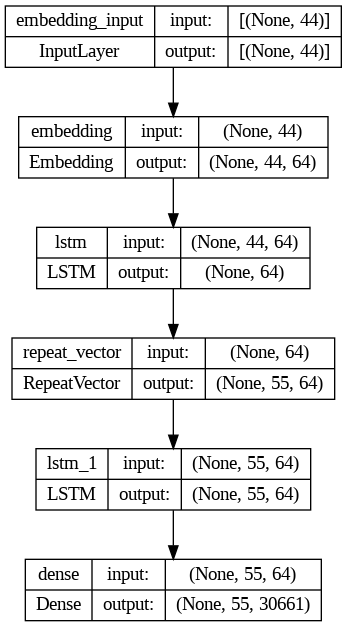

In [30]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

**Train Model**

Będziemy trenować  model przez 10 epok i przy wielkości partii 64 z podziałem walidacji wynoszącym 10%. 90% danych zostanie wykorzystanych do szkolenia modelu, a reszta do jego oceny.

Wykorzystamy także funkcję ModelCheckpoint(), aby zapisać model z najniższą utratą walidacji.



In [25]:
fn = 'model.h1.MT'
epoch = 2
val_split = 0.1

#Checkpoint
checkpoint = ModelCheckpoint(fn, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#proces uczenia
history = model.fit(train_X_seq, train_Y_seq,
                    epochs=epoch, batch_size=batch_size, validation_split = val_split, callbacks=[checkpoint],
                    verbose=1)

Epoch 1/2
2223/2223 [==============================] - ETA: 0s - loss: 1.0778
Epoch 1: val_loss improved from inf to 0.81704, saving model to model.h1.MT
2223/2223 [==============================] - 89s 36ms/step - loss: 1.0778 - val_loss: 0.8170
Epoch 2/2
2223/2223 [==============================] - ETA: 0s - loss: 0.7966
Epoch 2: val_loss improved from 0.81704 to 0.77560, saving model to model.h1.MT
2223/2223 [==============================] - 68s 31ms/step - loss: 0.7966 - val_loss: 0.7756


In [31]:
import joblib

In [32]:
model_saved = joblib.load('/content/drive/MyDrive/dane/modele/en-fr-translation.pkl')

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.title("Trening i Walidacja  - Loss", fontsize=15)
plt.show()

**Prediction**

In [67]:
test_X_seq[150]

array([ 14,   6,  39,  12, 468,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=int32)

In [68]:
test_data['Eng'][150]

'This is how it works.'

In [69]:
test_data['Frn'][150]

"C'est comme ça que cela fonctionne."

In [70]:
#proces Predicji
predictions = model_saved.predict(test_X_seq[1:200]) # 0 - wybieramy wynik predykcji dla 5 zdania w zbiorze testowym dla ]

# wynikie predykcji jest wektor prawdopodobieńst.
# Wielkość wektora jest uzalezniona od wielkości słownika (tutaj francuskiego) = 30661 unikalnych wyrazów



7/7 [==============================] - 4s 584ms/step


In [43]:
# funkcja wyznacza listę maksymalnych  prawdopodobieństw.
# na podstawie indeksu maksymalnych prawdopodobieństw są wskazywane wyrazy ze słownika (tutaj francyskieg)
# wyrazy te są sklejany w cia wyrazó , który stanowi wynik tłumaczenia

def to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [74]:


print(to_text(predictions[13], frn_tok))



je ne que de de de                                                 
